In [1]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import copy

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *

# ResRNN (Model 4)
Try a recurrent neural network that accumulates implied storages explicitly (doing away with LSTM memory cell). Instead of relying on gates to learn mass balance, we can enforce storage accumulation directly. Potentially comparable performance for much fewer parameters.

## Data Processing
Read Shasta data

In [3]:
def data_processing(name, transform_type, train_frac=0.6, val_frac=0.2, test_frac=0.2, 
                    left='1944-01-01', right='2022-12-31', log_names=[], return_scaler=False, storage=False):
    """
    Run data processing pipeline.
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, 
                                   chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow, STORAGE, and doy as input features
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [4]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processing('Shasta', transform_type='standardize',
                                                                       storage=False)

In [5]:
# Get observed storages
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

# Check lengths of train/val/test sets
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * 0.6))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * 0.2))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

# Get observed storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

## Analyze Hyperpamaraters

In [6]:
# load in results from grid search (averaged over random seeds)
grid_df_mean_resrnn = pd.read_csv('report/results/hyperparameter_tuning/resRNN_avg_tuning.csv', index_col=0)
grid_df_mean_resrnn[:10]

,hidden_size,dropout,epochs_trained,val_error
param_id,,,,
29,50.0,0.7,115.4,0.375978
17,40.0,0.5,112.6,0.379122
6,35.0,0.3,78.8,0.388504
7,40.0,0.3,73.8,0.392268
16,35.0,0.5,115.4,0.392627
19,50.0,0.5,93.4,0.393424
25,30.0,0.7,133.6,0.398853
5,30.0,0.3,82.8,0.399168
8,45.0,0.3,71.6,0.399773


In [7]:
# Plot grid search results
import plotly.express as px
plot_data = grid_df_mean_resrnn.copy()
fig = px.parallel_categories(plot_data, color='val_error',
                              dimensions=plot_data.drop(columns=['val_error', 'epochs_trained']).columns,
                              color_continuous_scale=px.colors.sequential.Turbo,
                              color_continuous_midpoint=plot_data.val_error.median(),
                              labels={'hidden_size':'Hidden size', 'dropout':'Dropout probability',
                  'val_error':'Val error'})
fig.show()

## Load ResRNN Model

In [8]:
# Create PyTorch dataset and dataloader
dataset_train, dataset_val = (TensorDataset(X_train, y_train), TensorDataset(X_val, y_val))
# shuffle = False to preserve time order
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                    DataLoader(dataset_val, batch_size=1, shuffle=False))

In [9]:
# Instantiate model (with optimal hyperparameters)
input_size = 2
hidden_size = 50
output_size = 1
dropout_prob = 0.7
torch.manual_seed(0)
model = resRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
               dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# load saved model
model.load_state_dict(torch.load('src/models/saved_models/resRNN.pt'))

# turn model into evaluation model
model.eval()

C:\Users\mattc\AppData\Local\Temp\ipykernel_7412\2474092493.py:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



resRNN(
  (linear1): Linear(in_features=53, out_features=50, bias=True)
  (tanh1): Tanh()
  (dropout1): Dropout(p=0.7, inplace=False)
  (linear2): Linear(in_features=50, out_features=1, bias=True)
)

## Plot Results

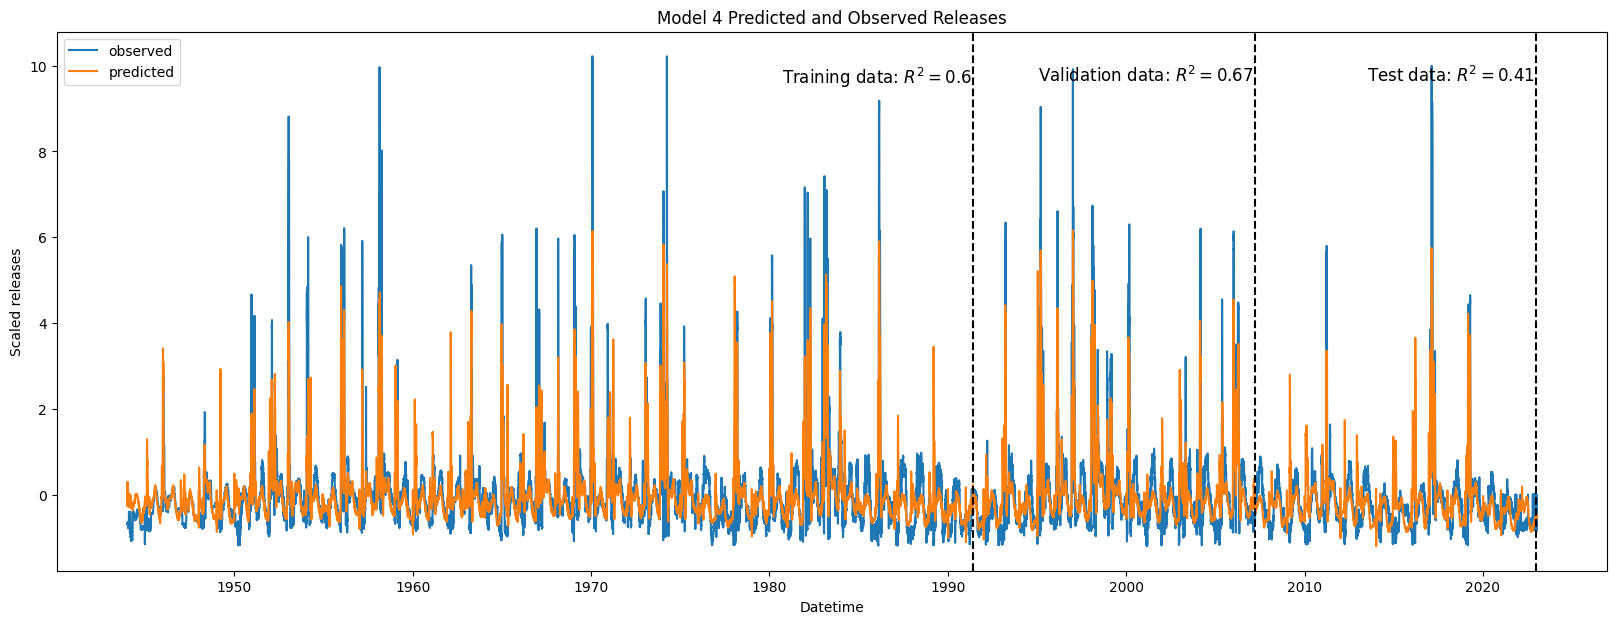

In [10]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_and_eval(model=model, X_train=X_train, X_val=X_val, X_test=X_test,
              y_train=y_train, y_val=y_val, y_test=y_test,
              datetime_index=pd.date_range(start='1944-01-01', end='2022-12-31', freq='D'),
              text_ypos=10, ax=ax)
plt.title('Model 4 Predicted and Observed Releases')
plt.savefig('report/drafting/3_28_2024/figures/ResRNN_observed_predicted.png', dpi=300)
plt.show()

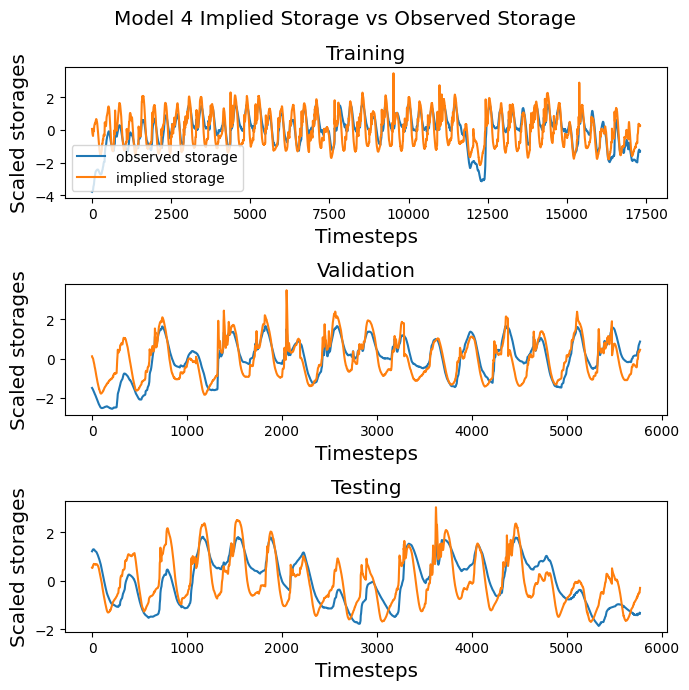

In [13]:
# Plot implied storages, shape is (# chunks, timesteps, hidden size)
from src.models.analyze_lstm_cell import plot_storage_cell
with torch.no_grad():
    model.eval()
    im_storage_train = model(X_train)[1].detach()
    im_storage_val = model(X_val)[1].detach()
    im_storage_test = model(X_test)[1].detach()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))
plot_storage_cell(cell_states_all=im_storage_train, storage_states=storage_train, cell_id=0, ax=axes[0])
axes[0].legend(['observed storage', 'implied storage'], loc='lower left')
axes[0].set_title('Training', size='x-large')
axes[0].set_xlabel('Timesteps', size='x-large')
axes[0].set_ylabel('Scaled storages', size='x-large')

plot_storage_cell(cell_states_all=im_storage_val, storage_states=storage_val, cell_id=0, ax=axes[1])
axes[1].set_title('Validation', size='x-large')
axes[1].set_xlabel('Timesteps', size='x-large')
axes[1].set_ylabel('Scaled storages', size='x-large')

plot_storage_cell(cell_states_all=im_storage_test, storage_states=storage_test, cell_id=0, ax=axes[2])
axes[2].set_title('Testing', size='x-large')
axes[2].set_xlabel('Timesteps', size='x-large')
axes[2].set_ylabel('Scaled storages', size='x-large')

fig.suptitle('Model 4 Implied Storage vs Observed Storage', size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/figures/model4_implied_storage.png', dpi=300)
plt.show()

## Number of Parameters

In [12]:
count_parameters(model)

2751

In [14]:
# Compare to LSTM Model 1
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1

torch.manual_seed(0)
model1 = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                                            hidden_size2=hidden_size2, output_size=output_size, 
                                            num_layers=num_layers, dropout_prob=dropout_prob)
count_parameters(model1)

4561

In [16]:
count_parameters(model) / count_parameters(model1)

0.6031572023679018

## Side Experiment: Sensitivity to Sequence Length
Try different sequence lengths on Model 1 for Shasta Reservoir

In [8]:
def data_processing_seq_len(name, transform_type, seq_len, train_frac=0.6, val_frac=0.2, test_frac=0.2, 
                    left='1944-01-01', right='2022-12-31', log_names=[], return_scaler=False, storage=False):
    """
    Run data processing pipeline.
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    seq_len -- int, sequence length of split chunks
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, 
                                   chunk_size=seq_len, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow, STORAGE, and doy as input features
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [13]:
def train_eval_seq_len(seq_len, name='Shasta', left='1944-01-01', right='2022-12-31'):
    """ 
    Train and evaluate R2 score on Model 1 for different sequence lengths
    """
    # Data processing (vary sequence length)
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processing_seq_len(name=name, transform_type='standardize',
                                                                                   seq_len=seq_len, left=left, right=right)
    print(f'X_train shape: {X_train.shape}')
    
    # Instantiate model
    input_size = 2 # inflow, doy
    hidden_size1 = 30
    hidden_size2 = 15
    output_size = 1
    dropout_prob = 0.3
    num_layers = 1

    torch.manual_seed(0)
    model = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                                               hidden_size2=hidden_size2, output_size=output_size, 
                                               num_layers=num_layers, dropout_prob=dropout_prob)
    dataset_train, dataset_val = (TensorDataset(X_train, y_train), 
                                          TensorDataset(X_val, y_val))
    dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                DataLoader(dataset_val, batch_size=1, shuffle=False))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Run training loop
    train_losses, val_losses = training_loop(model=model, criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train, 
                                            dataloader_val=dataloader_val, epochs=1000)
    
    # Evaluate model
    return eval_train_val_test(model, X_train, X_val, X_test, y_train, y_val, y_test)

In [14]:
# Different sequence lengths to try
seq_len_list = [round(0.5*365), 365, 2*365, 3*365, 4*365, 5*365]
# Store results in df
seq_len_df = pd.DataFrame(index=seq_len_list, columns=['train', 'val', 'test'])

In [15]:
for seq_len in seq_len_list:
    seq_len_df.loc[seq_len, :] = train_eval_seq_len(seq_len=seq_len)

X_train shape: torch.Size([96, 182, 2])


Training epochs:   3%|▎         | 29/1000 [00:12<07:08,  2.27it/s]


X_train shape: torch.Size([48, 365, 2])


Training epochs:   4%|▍         | 41/1000 [00:11<04:39,  3.43it/s]


X_train shape: torch.Size([24, 730, 2])


Training epochs:   8%|▊         | 82/1000 [00:20<03:48,  4.02it/s]


X_train shape: torch.Size([16, 1095, 2])


Training epochs:   7%|▋         | 72/1000 [00:15<03:21,  4.61it/s]


X_train shape: torch.Size([12, 1460, 2])


Training epochs:   8%|▊         | 76/1000 [00:15<03:11,  4.82it/s]


X_train shape: torch.Size([10, 1825, 2])


Training epochs:   4%|▍         | 43/1000 [00:08<03:15,  4.90it/s]


In [16]:
seq_len_df

,train,val,test
182,0.660079,0.6244,0.434428
365,0.667722,0.63221,0.47645
730,0.72096,0.668048,0.45166
1095,0.731914,0.686335,0.433781
1460,0.71504,0.661911,0.524787
1825,0.64869,0.624828,0.525457
